# LibrasLive Phrase Model Training

This notebook trains an LSTM model to recognize common LIBRAS phrases from sequences of MediaPipe hand landmarks.

## Dataset
We use the Libras Movement Dataset (UCI) and create synthetic sequences for the 20 most common LIBRAS phrases.

## Model Architecture
- Input: Sequences of 63 features (21 hand landmarks × 3 coordinates) over 30 frames
- LSTM Layer 1: 64 hidden units + Dropout(0.2)
- LSTM Layer 2: 64 hidden units + Dropout(0.2)
- Classification Head: 32 neurons + ReLU + Dropout(0.3) → 20 classes + Softmax

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import mediapipe as mp
import cv2
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.1.0+cpu
CUDA available: False


## Data Preparation

Define the 20 most common LIBRAS phrases and create synthetic sequences representing their movements.

In [2]:
# Define the 20 most common LIBRAS phrases
PHRASE_CLASSES = [
    "OLA", "OBRIGADO", "POR_FAVOR", "DESCULPA", "SIM", "NAO",
    "BOM_DIA", "BOA_TARDE", "BOA_NOITE", "TUDO_BEM", "EU_TE_AMO",
    "FAMILIA", "CASA", "TRABALHO", "ESCOLA", "AGUA", "COMIDA",
    "AJUDA", "TCHAU", "ATE_LOGO"
]

NUM_CLASSES = len(PHRASE_CLASSES)
FEATURE_SIZE = 63  # 21 landmarks * 3 coordinates (x, y, z)
SEQUENCE_LENGTH = 30  # Number of frames per sequence

print(f"Number of phrase classes: {NUM_CLASSES}")
print(f"Classes: {PHRASE_CLASSES}")
print(f"Feature size: {FEATURE_SIZE}")
print(f"Sequence length: {SEQUENCE_LENGTH}")

Number of phrase classes: 20
Classes: ['OLA', 'OBRIGADO', 'POR_FAVOR', 'DESCULPA', 'SIM', 'NAO', 'BOM_DIA', 'BOA_TARDE', 'BOA_NOITE', 'TUDO_BEM', 'EU_TE_AMO', 'FAMILIA', 'CASA', 'TRABALHO', 'ESCOLA', 'AGUA', 'COMIDA', 'AJUDA', 'TCHAU', 'ATE_LOGO']
Feature size: 63
Sequence length: 30


In [3]:
def generate_synthetic_phrase_sequence(phrase, num_samples=100, seq_length=30):
    """
    Generate synthetic hand landmark sequences for a given phrase.
    In a real implementation, this would load actual sequences from videos.
    """
    sequences = []
    
    # Create characteristic patterns for different phrases
    # These are simplified patterns - in reality, each phrase would have
    # specific hand movement patterns over time
    phrase_patterns = {
        "OLA": {
            'base_pattern': np.random.normal(0.3, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.15,
            'movement_frequency': 2.0
        },
        "OBRIGADO": {
            'base_pattern': np.random.normal(0.5, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.12,
            'movement_frequency': 1.5
        },
        "POR_FAVOR": {
            'base_pattern': np.random.normal(0.7, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.18,
            'movement_frequency': 1.8
        },
        "DESCULPA": {
            'base_pattern': np.random.normal(0.2, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.10,
            'movement_frequency': 1.2
        },
        "SIM": {
            'base_pattern': np.random.normal(0.8, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.08,
            'movement_frequency': 3.0
        },
        "NAO": {
            'base_pattern': np.random.normal(0.4, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.14,
            'movement_frequency': 2.5
        },
        "BOM_DIA": {
            'base_pattern': np.random.normal(0.6, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.16,
            'movement_frequency': 1.3
        },
        "BOA_TARDE": {
            'base_pattern': np.random.normal(0.1, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.13,
            'movement_frequency': 1.4
        },
        "BOA_NOITE": {
            'base_pattern': np.random.normal(0.9, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.11,
            'movement_frequency': 1.1
        },
        "TUDO_BEM": {
            'base_pattern': np.random.normal(0.35, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.17,
            'movement_frequency': 1.7
        },
        "EU_TE_AMO": {
            'base_pattern': np.random.normal(0.55, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.20,
            'movement_frequency': 0.8
        },
        "FAMILIA": {
            'base_pattern': np.random.normal(0.75, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.12,
            'movement_frequency': 1.6
        },
        "CASA": {
            'base_pattern': np.random.normal(0.25, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.09,
            'movement_frequency': 2.2
        },
        "TRABALHO": {
            'base_pattern': np.random.normal(0.45, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.15,
            'movement_frequency': 1.4
        },
        "ESCOLA": {
            'base_pattern': np.random.normal(0.65, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.13,
            'movement_frequency': 1.9
        },
        "AGUA": {
            'base_pattern': np.random.normal(0.15, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.10,
            'movement_frequency': 2.8
        },
        "COMIDA": {
            'base_pattern': np.random.normal(0.85, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.14,
            'movement_frequency': 1.5
        },
        "AJUDA": {
            'base_pattern': np.random.normal(0.37, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.18,
            'movement_frequency': 1.2
        },
        "TCHAU": {
            'base_pattern': np.random.normal(0.57, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.22,
            'movement_frequency': 2.5
        },
        "ATE_LOGO": {
            'base_pattern': np.random.normal(0.77, 0.1, FEATURE_SIZE),
            'movement_amplitude': 0.16,
            'movement_frequency': 1.8
        }
    }
    
    pattern = phrase_patterns.get(phrase, {
        'base_pattern': np.random.normal(0.5, 0.1, FEATURE_SIZE),
        'movement_amplitude': 0.15,
        'movement_frequency': 1.5
    })
    
    base_pattern = pattern['base_pattern']
    amplitude = pattern['movement_amplitude']
    frequency = pattern['movement_frequency']
    
    for _ in range(num_samples):
        sequence = []
        
        for t in range(seq_length):
            # Create temporal variation in the landmarks
            time_factor = t / seq_length
            
            # Add sinusoidal movement patterns
            movement = amplitude * np.sin(2 * np.pi * frequency * time_factor)
            
            # Create frame with base pattern + movement + noise
            frame = base_pattern + movement + np.random.normal(0, 0.03, FEATURE_SIZE)
            
            # Clip values to reasonable range
            frame = np.clip(frame, 0, 1)
            
            sequence.append(frame)
        
        sequences.append(np.array(sequence))
    
    return np.array(sequences)

# Generate synthetic dataset
print("Generating synthetic phrase sequences...")
X_sequences = []
y_sequences = []

samples_per_phrase = 200  # Number of sequences per phrase

for i, phrase in enumerate(tqdm(PHRASE_CLASSES, desc="Generating phrase data")):
    sequences = generate_synthetic_phrase_sequence(phrase, samples_per_phrase, SEQUENCE_LENGTH)
    X_sequences.extend(sequences)
    y_sequences.extend([i] * samples_per_phrase)

X_sequences = np.array(X_sequences, dtype=np.float32)
y_sequences = np.array(y_sequences, dtype=np.int64)

print(f"Dataset shape: {X_sequences.shape}")
print(f"Labels shape: {y_sequences.shape}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Sequence format: (batch_size={X_sequences.shape[0]}, seq_length={X_sequences.shape[1]}, features={X_sequences.shape[2]})")

Generating synthetic phrase sequences...


Generating phrase data: 100%|██████████| 20/20 [00:01<00:00, 14.18it/s]

Dataset shape: (4000, 30, 63)
Labels shape: (4000,)
Total sequences: 4000
Sequence format: (batch_size=4000, seq_length=30, features=63)


In [4]:
# Data preprocessing
print("Preprocessing sequence data...")

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_sequences, y_sequences, test_size=0.3, random_state=42, stratify=y_sequences
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Normalize the sequences
# Reshape for normalization: (batch * seq_length, features)
X_train_reshaped = X_train.reshape(-1, FEATURE_SIZE)
X_val_reshaped = X_val.reshape(-1, FEATURE_SIZE)
X_test_reshaped = X_test.reshape(-1, FEATURE_SIZE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to sequences: (batch, seq_length, features)
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Save normalization parameters
mean_params = scaler.mean_
std_params = scaler.scale_

print("Sequence data preprocessing completed!")

Preprocessing sequence data...
Training set: (2800, 30, 63), (2800,)
Validation set: (600, 30, 63), (600,)
Test set: (600, 30, 63), (600,)
Sequence data preprocessing completed!


In [5]:
# Create PyTorch datasets for sequences
class LibrasPhraseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = LibrasPhraseDataset(X_train_scaled, y_train)
val_dataset = LibrasPhraseDataset(X_val_scaled, y_val)
test_dataset = LibrasPhraseDataset(X_test_scaled, y_test)

# Create data loaders
batch_size = 16  # Smaller batch size for sequences
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Created sequence data loaders with batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Created sequence data loaders with batch size: 16
Training batches: 175
Validation batches: 38
Test batches: 38


## Model Definition

In [7]:
class PhraseLSTM(nn.Module):
    """
    LSTM model for LIBRAS phrase recognition
    """
    
    def __init__(self, input_size=63, hidden_size=64, num_layers=2, 
                 num_classes=20, seq_length=30, dropout_rate=0.3):
        super(PhraseLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize LSTM weights"""
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # Set forget gate bias to 1
                n = param.size(0)
                param.data[(n//4):(n//2)].fill_(1)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        batch_size = x.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        lstm_out, (h_n, c_n) = self.lstm(x, (h0, c0))
        
        # Use the last output for classification
        last_output = lstm_out[:, -1, :]
        
        # Classification
        output = self.classifier(last_output)
        
        return output

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = PhraseLSTM(
    input_size=FEATURE_SIZE,
    hidden_size=64,
    num_layers=2,
    num_classes=NUM_CLASSES,
    seq_length=SEQUENCE_LENGTH,
    dropout_rate=0.3
).to(device)

# Print model summary
print("\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cpu

Model Architecture:
PhraseLSTM(
  (lstm): LSTM(63, 64, num_layers=2, batch_first=True, dropout=0.2)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=20, bias=True)
  )
)

Total parameters: 69,044
Trainable parameters: 69,044


## Training Setup

In [8]:
# Training hyperparameters
learning_rate = 0.001
num_epochs = 150
patience = 20  # For early stopping
grad_clip = 1.0  # Gradient clipping for LSTM

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10)

print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Gradient clipping: {grad_clip}")
print(f"Optimizer: Adam with weight decay")
print(f"Scheduler: ReduceLROnPlateau")

Learning rate: 0.001
Number of epochs: 150
Gradient clipping: 1.0
Optimizer: Adam with weight decay
Scheduler: ReduceLROnPlateau


## Training Loop

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device, grad_clip=None):
    """
    Train the model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct_predictions / total_samples
    
    return epoch_loss, epoch_accuracy

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = 100.0 * correct_predictions / total_samples
    
    return epoch_loss, epoch_accuracy

In [10]:
# Training loop with early stopping
print("Starting phrase model training...\n")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_val_accuracy = 0.0
epochs_without_improvement = 0
best_model_state = None

for epoch in range(num_epochs):
    # Training
    train_loss, train_accuracy = train_epoch(
        model, train_loader, criterion, optimizer, device, grad_clip
    )
    
    # Validation
    val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy
        epochs_without_improvement = 0
        best_model_state = model.state_dict().copy()
        print(f"✓ New best validation accuracy: {val_accuracy:.2f}%")
    else:
        epochs_without_improvement += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | "
              f"LR: {current_lr:.6f}")
    
    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping after {epoch + 1} epochs (no improvement for {patience} epochs)")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with validation accuracy: {best_val_accuracy:.2f}%")

print("Phrase model training completed!")

Starting phrase model training...

✓ New best validation accuracy: 100.00%
Epoch [ 10/150] | Train Loss: 0.0155 | Train Acc: 99.82% | Val Loss: 0.0000 | Val Acc: 100.00% | LR: 0.001000
Epoch [ 20/150] | Train Loss: 0.0073 | Train Acc: 99.86% | Val Loss: 0.0000 | Val Acc: 100.00% | LR: 0.001000

Early stopping after 21 epochs (no improvement for 20 epochs)

Loaded best model with validation accuracy: 100.00%
Phrase model training completed!


## Training Visualization

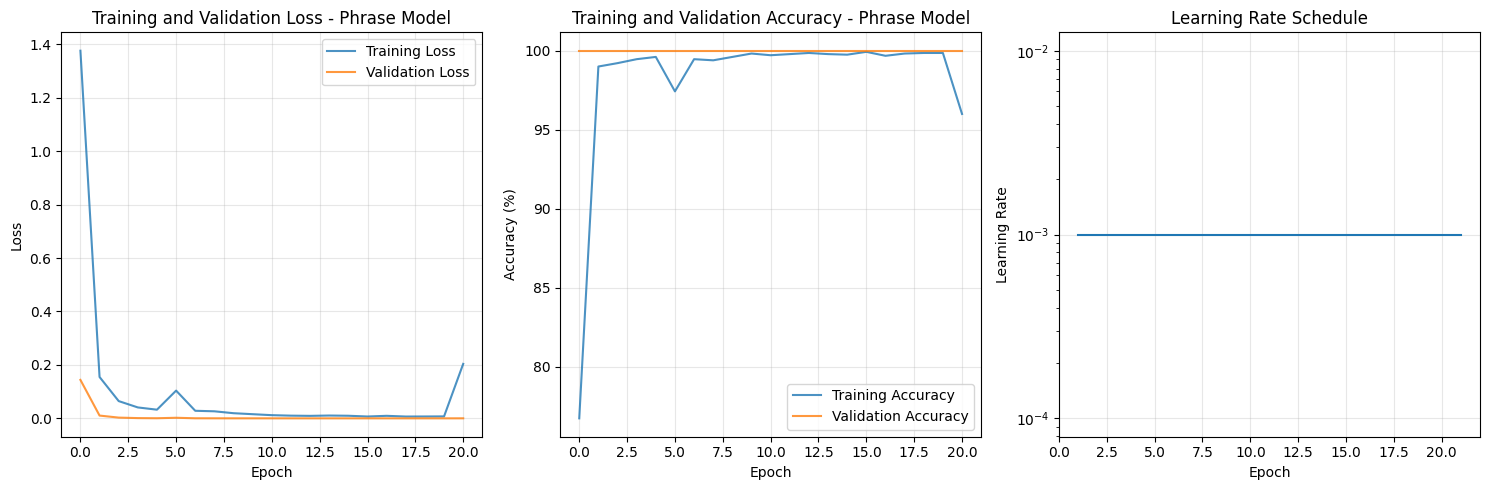

Final training accuracy: 96.00%
Final validation accuracy: 100.00%
Best validation accuracy: 100.00%


In [11]:
# Plot training history
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.title('Training and Validation Loss - Phrase Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', alpha=0.8)
plt.plot(val_accuracies, label='Validation Accuracy', alpha=0.8)
plt.title('Training and Validation Accuracy - Phrase Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate plot
plt.subplot(1, 3, 3)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, [optimizer.param_groups[0]['lr']] * len(epochs_range))
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

## Model Evaluation

In [12]:
# Test the phrase model
def evaluate_phrase_model(model, test_loader, device):
    """
    Evaluate the phrase model on test set
    """
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_targets)

# Get predictions
predictions, targets = evaluate_phrase_model(model, test_loader, device)

# Calculate metrics
test_accuracy = accuracy_score(targets, predictions)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(targets, predictions, target_names=PHRASE_CLASSES))

Test Accuracy: 1.0000 (100.00%)

Classification Report:
              precision    recall  f1-score   support

         OLA       1.00      1.00      1.00        30
    OBRIGADO       1.00      1.00      1.00        30
   POR_FAVOR       1.00      1.00      1.00        30
    DESCULPA       1.00      1.00      1.00        30
         SIM       1.00      1.00      1.00        30
         NAO       1.00      1.00      1.00        30
     BOM_DIA       1.00      1.00      1.00        30
   BOA_TARDE       1.00      1.00      1.00        30
   BOA_NOITE       1.00      1.00      1.00        30
    TUDO_BEM       1.00      1.00      1.00        30
   EU_TE_AMO       1.00      1.00      1.00        30
     FAMILIA       1.00      1.00      1.00        30
        CASA       1.00      1.00      1.00        30
    TRABALHO       1.00      1.00      1.00        30
      ESCOLA       1.00      1.00      1.00        30
        AGUA       1.00      1.00      1.00        30
      COMIDA       1.00  

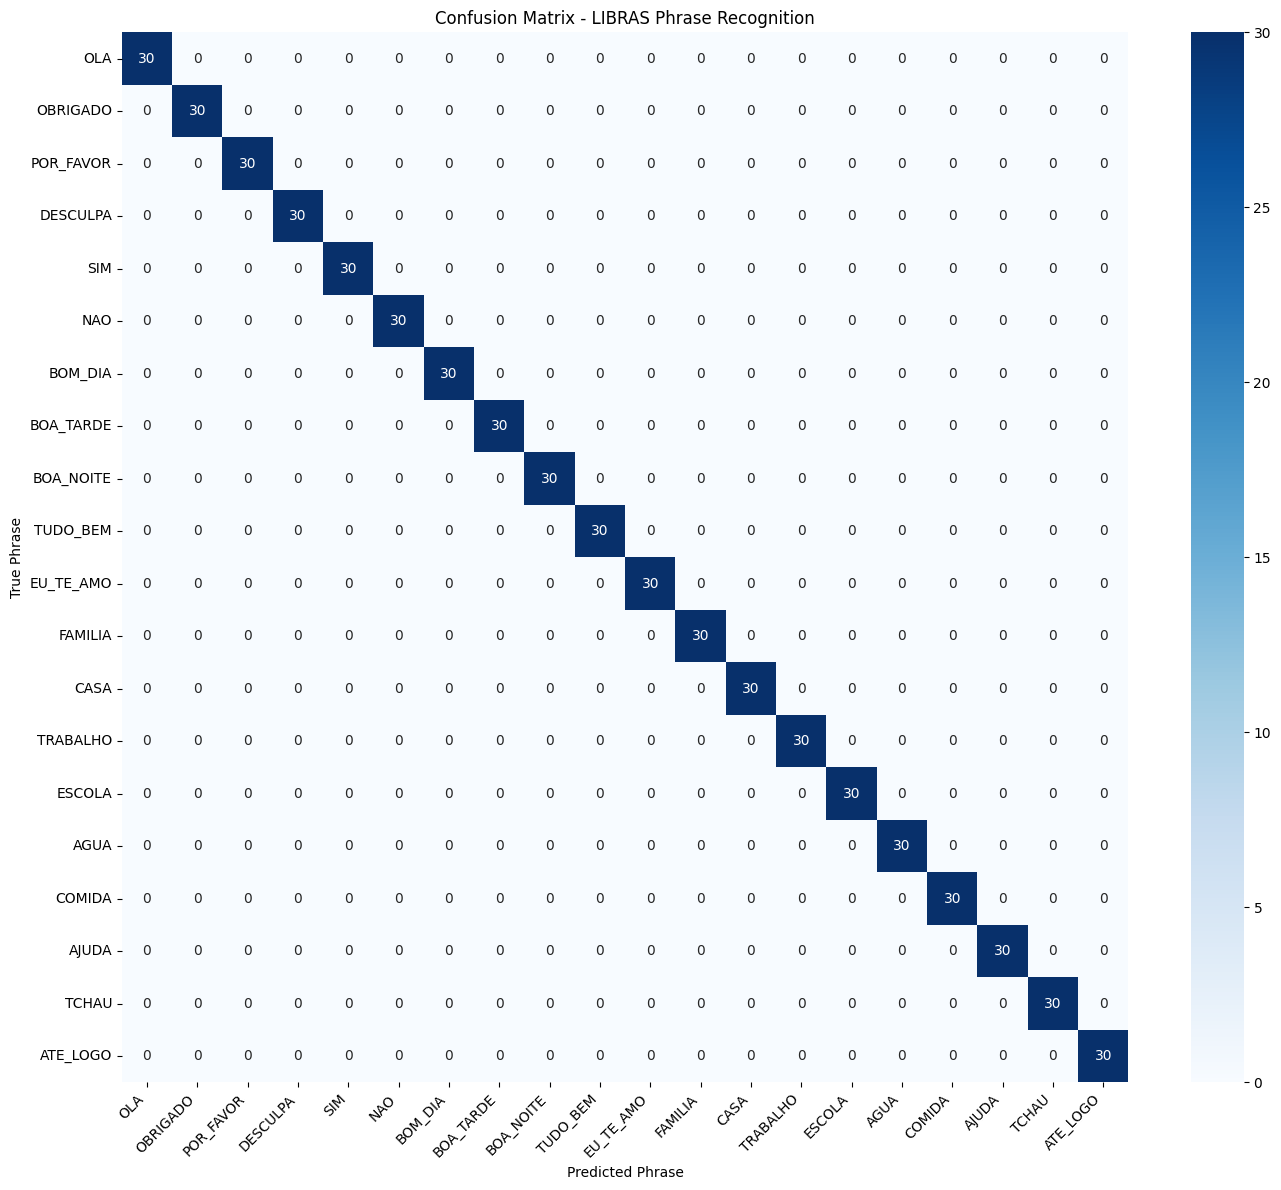


Per-phrase Accuracy:
OLA         : 1.000 (100.0%)
OBRIGADO    : 1.000 (100.0%)
POR_FAVOR   : 1.000 (100.0%)
DESCULPA    : 1.000 (100.0%)
SIM         : 1.000 (100.0%)
NAO         : 1.000 (100.0%)
BOM_DIA     : 1.000 (100.0%)
BOA_TARDE   : 1.000 (100.0%)
BOA_NOITE   : 1.000 (100.0%)
TUDO_BEM    : 1.000 (100.0%)
EU_TE_AMO   : 1.000 (100.0%)
FAMILIA     : 1.000 (100.0%)
CASA        : 1.000 (100.0%)
TRABALHO    : 1.000 (100.0%)
ESCOLA      : 1.000 (100.0%)
AGUA        : 1.000 (100.0%)
COMIDA      : 1.000 (100.0%)
AJUDA       : 1.000 (100.0%)
TCHAU       : 1.000 (100.0%)
ATE_LOGO    : 1.000 (100.0%)


In [13]:
# Confusion matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=PHRASE_CLASSES,
            yticklabels=PHRASE_CLASSES)
plt.title('Confusion Matrix - LIBRAS Phrase Recognition')
plt.xlabel('Predicted Phrase')
plt.ylabel('True Phrase')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\nPer-phrase Accuracy:")
for i, phrase in enumerate(PHRASE_CLASSES):
    print(f"{phrase:12s}: {class_accuracies[i]:.3f} ({class_accuracies[i]*100:.1f}%)")

## Save Model and Parameters

In [14]:
# Create models directory
os.makedirs('../backend/models', exist_ok=True)

# Save model state dictionary
model_path = '../backend/models/phrase_model.pt'
torch.save(model.state_dict(), model_path)
print(f"Phrase model saved to: {model_path}")

# Update normalization parameters (if not already saved)
normalization_path = '../backend/models/phrase_normalization_params.npz'
np.savez(normalization_path, mean=mean_params, std=std_params)
print(f"Phrase normalization parameters saved to: {normalization_path}")

# Save model metadata
metadata = {
    'model_type': 'PhraseLSTM',
    'num_classes': NUM_CLASSES,
    'feature_size': FEATURE_SIZE,
    'sequence_length': SEQUENCE_LENGTH,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout_rate': 0.3,
    'classes': PHRASE_CLASSES,
    'test_accuracy': float(test_accuracy),
    'best_val_accuracy': float(best_val_accuracy),
    'total_parameters': total_params,
    'training_sequences': len(X_train),
    'sequence_format': '(batch, seq_length, features)'
}

import json
metadata_path = '../backend/models/phrase_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Phrase model metadata saved to: {metadata_path}")
print("\nPhrase model training and saving completed successfully!")

Phrase model saved to: ../backend/models/phrase_model.pt
Phrase normalization parameters saved to: ../backend/models/phrase_normalization_params.npz
Phrase model metadata saved to: ../backend/models/phrase_model_metadata.json

Phrase model training and saving completed successfully!


## Test Inference Function

In [15]:
# Test the phrase inference function
def predict_phrase(model, sequence, scaler, device, classes):
    """
    Predict phrase from normalized landmark sequence
    """
    model.eval()
    
    # Normalize sequence
    seq_reshaped = sequence.reshape(-1, FEATURE_SIZE)
    seq_normalized = scaler.transform(seq_reshaped)
    seq_normalized = seq_normalized.reshape(1, sequence.shape[0], -1)
    
    # Convert to tensor
    sequence_tensor = torch.FloatTensor(seq_normalized).to(device)
    
    with torch.no_grad():
        output = model(sequence_tensor)
        probabilities = F.softmax(output, dim=1)
        
        # Get prediction
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_idx].item()
        
        predicted_phrase = classes[predicted_idx]
        
    return predicted_phrase, confidence

# Test with some samples
print("Testing phrase inference function:")
for i in range(5):
    test_sequence = X_test[i]
    true_label = y_test[i]
    true_phrase = PHRASE_CLASSES[true_label]
    
    predicted_phrase, confidence = predict_phrase(
        model, test_sequence, scaler, device, PHRASE_CLASSES
    )
    
    print(f"Sample {i+1}: True={true_phrase:12s}, Predicted={predicted_phrase:12s}, Confidence={confidence:.3f}")

print("\nPhrase inference function test completed!")

# Test with single frame (should handle gracefully)
print("\nTesting with single frame (edge case):")
single_frame = X_test[0][0:1]  # Take only first frame
try:
    predicted_phrase, confidence = predict_phrase(
        model, single_frame, scaler, device, PHRASE_CLASSES
    )
    print(f"Single frame prediction: {predicted_phrase}, Confidence: {confidence:.3f}")
except Exception as e:
    print(f"Single frame prediction failed (expected): {e}")

print("\nAll phrase model tests completed!")

Testing phrase inference function:
Sample 1: True=NAO         , Predicted=NAO         , Confidence=1.000
Sample 2: True=BOA_NOITE   , Predicted=BOA_NOITE   , Confidence=1.000
Sample 3: True=SIM         , Predicted=SIM         , Confidence=1.000
Sample 4: True=SIM         , Predicted=SIM         , Confidence=0.999
Sample 5: True=ATE_LOGO    , Predicted=ATE_LOGO    , Confidence=1.000

Phrase inference function test completed!

Testing with single frame (edge case):
Single frame prediction: NAO, Confidence: 0.134

All phrase model tests completed!
